In [2]:
"""
Pattern Recognition and Machine Learning
Programming Exercise: 02
Name: Vo Thi Khanh Linh
Student ID: 21280070
"""

'\nPattern Recognition and Machine Learning\nProgramming Exercise: 02\nName: Vo Thi Khanh Linh\nStudent ID: 21280070\n'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd /content/drive/MyDrive/Colab Notebooks/NDM/

/content/drive/MyDrive/Colab Notebooks/NDM


#Data Exploration

Data was downloaded from https://drive.google.com/drive/folders/1HooABJyrddVGzll7fgkJ6VzkG_XuWfRu


##Load and explore the dataset

In [6]:
train_data = pd.read_excel('train_nor_811.xlsx')

The first step is to explore the data in the training set, which consists of 3 fields. The first field is the ID (which is not used), followed by 'Emotion' and 'Sentence'.

In [7]:
train_data.rename(columns = {list(train_data)[0]:'ID'}, inplace=True)

In [8]:
train_data.columns

Index(['ID', 'Emotion', 'Sentence'], dtype='object')

I tried reading a few sentences from the dataset and noticed that it needs preprocessing and careful cleaning before being used as input for a model.

In [9]:
train_data

,ID,Emotion,Sentence
0,188,Other,cho mình xin bài nhạc tên là gì với ạ
1,166,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,1345,Disgust,lo học đi . yêu đương lol gì hay lại thích học...
3,316,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :))
4,1225,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...
...,...,...,...
5543,1332,Disgust,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...
5544,825,Other,nhìn mặt héo queo luôn
5545,165,Other,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...
5546,363,Enjoyment,thích thân hình boss rồi nhan 😌


The next step is to count the frequency of occurrences of each emotion in the dataset.

In [10]:
train_data.Emotion.value_counts()

Enjoyment    1558
Disgust      1071
Other        1021
Sadness       947
Anger         391
Fear          318
Surprise      242
Name: Emotion, dtype: int64

## Analyze the distribution of emotions

Now, let's analyze the distribution of the different emotions.

In [11]:
emotion_counts = train_data.Emotion.value_counts(normalize=True).reset_index()
emotion_counts.columns = ['Emotion Label', 'Percentage']
emotion_counts['Percentage'] *= 100
print(emotion_counts)

  Emotion Label  Percentage
0     Enjoyment   28.082192
1       Disgust   19.304254
2         Other   18.403028
3       Sadness   17.069214
4         Anger    7.047585
5          Fear    5.731795
6      Surprise    4.361932


I visualized the distribution of the labels to get a clearer picture:

In [12]:
import seaborn as sns

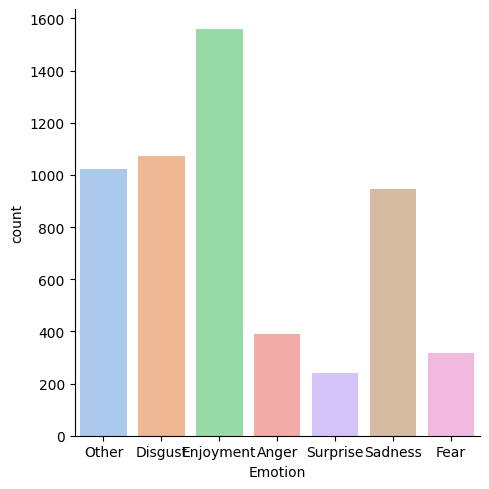

In [13]:
sns.catplot(train_data, x="Emotion", kind="count", palette="pastel")

In [14]:
train_pre = train_data.copy()

I have assigned numerical indices to the labels for consistency in visualizing and comparing distributions across the three datasets: train, validation, and test.

In [15]:
label2id = {"Anger": 0, "Disgust": 1, "Fear": 2,  "Sadness": 3, "Other": 4, "Enjoyment": 5, "Surprise": 6}
id2label = {0: "Anger", 1: "Disgust", 2: "Fear", 3: "Sadness", 4: "Other", 5: "Enjoyment", 6: "Surprise"}

In [16]:
train_pre.Emotion = train_pre.Emotion.map(label2id)

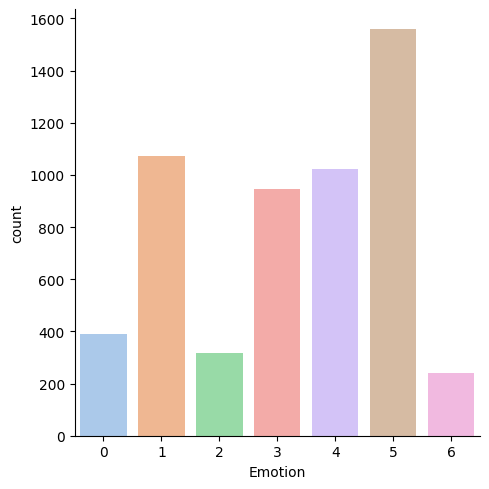

In [17]:
sns.catplot(train_pre, x="Emotion", kind="count", palette="pastel")

In [18]:
test_data = pd.read_excel('test_nor_811.xlsx')
valid_data = pd.read_excel('valid_nor_811.xlsx')

In [19]:
valid_data.Emotion = valid_data.Emotion.map(label2id)
test_data.Emotion = test_data.Emotion.map(label2id)

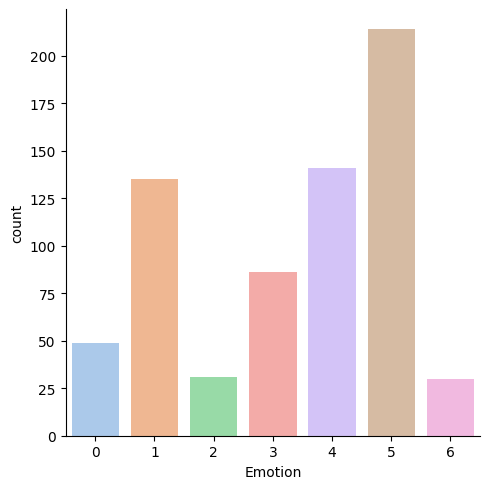

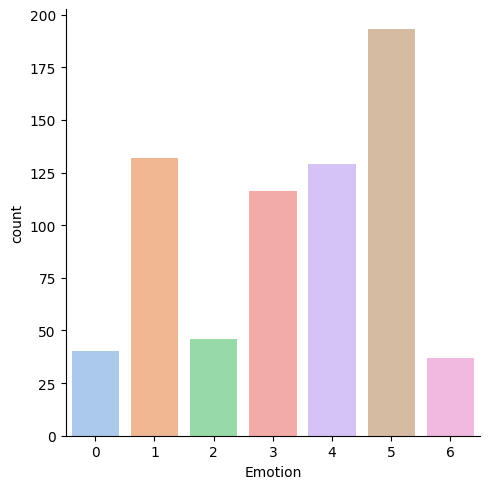

In [20]:
sns.catplot(valid_data, x="Emotion", kind="count", palette="pastel")
sns.catplot(test_data, x="Emotion", kind="count", palette="pastel")

**Comment: The distribution of emotions across the three sets appears quite similar and all exhibit imbalanced distributions.**


##Preprocess the text data

Now, let's begin cleaning the data to enhance the quality of input for the model.

### Standardizing words

UIT-VSMEC corpus contains several words that are not
in proper formats. For example, "luônnn" should be "luôn" (always) and "thích quáaaaa" should be "thích quá" (really enjoyable).

I partly solved this problem by using technique 1 - Standardizing words, in which I used regular expressions to replace a sequence of repeated characters by the character itself.

In [21]:
import re

In [22]:
def standardizing_word(text):
  modified_text = re.sub(r'(.)\1+', r'\1', text)
  return modified_text

In [23]:
train_pre.Sentence = train_pre.Sentence.apply(standardizing_word)

In [24]:
train_pre

,ID,Emotion,Sentence
0,188,4,cho mình xin bài nhạc tên là gì với ạ
1,166,1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,1345,1,lo học đi . yêu đương lol gì hay lại thích học...
3,316,5,uớc gì sau này về già vẫn có thể như cụ này :)
4,1225,5,mỗi lần có video của con là cứ coi đi coi lại ...
...,...,...,...
5543,1332,1,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...
5544,825,4,nhìn mặt héo queo luôn
5545,165,4,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...
5546,363,5,thích thân hình bos rồi nhan 😌


### Removing repeated emoji and emoticons in the same comment

To handle emojis and emoticons, my approach is to remove repeated emojis and emoticons in the same corpus, then transforming them into their word form.

I consider duplicated emojis and emoticons in the same corpus are noise data, and only the unique ones should be kept.

In [25]:
def remove_repeated_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)

    def remove_duplicates(match):
        return match.group(0)[0]

    cleaned_text = re.sub(emoji_pattern, remove_duplicates, text)
    return cleaned_text

In [26]:
train_pre.Sentence = train_pre.Sentence.apply(remove_repeated_emojis)
train_pre

,ID,Emotion,Sentence
0,188,4,cho mình xin bài nhạc tên là gì với ạ
1,166,1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,1345,1,lo học đi . yêu đương lol gì hay lại thích học...
3,316,5,uớc gì sau này về già vẫn có thể như cụ này :)
4,1225,5,mỗi lần có video của con là cứ coi đi coi lại ...
...,...,...,...
5543,1332,1,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...
5544,825,4,nhìn mặt héo queo luôn
5545,165,4,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...
5546,363,5,thích thân hình bos rồi nhan 😌


### Convert emoticons to emoji

I convert emoticons to emojis after transforming them into their word form.

In [27]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 3.2 MB/s eta 0:00:00


In [28]:
def convert_emoticons_to_emoji(text):
  emoticon_to_emoji = {
      ":)": "😊",
        ":-)": "😊",
        ":(": "☹️",
        ":-(": "☹️",
        ":D": "😃",
        ":-D": "😃",
        "<3": "❤️",
        ":P": "😛",
        ":-P": "😛",
        ";)": "😉",
        ";-)": "😉",
        ":|": "😐",
        ":-|": "😐",
        ":/": "😕",
        ":-/": "😕",
        ":O": "😲",
        ":-O": "😲",
        ":*": "😘",
        ":-*": "😘",
        ":')": "😂",
        ":'-)": "😂",
        ":X": "🤐",
        ":-X": "🤐",
        ":*(": "😢",
        ":-*(": "😢",
        ":\\": "😕",
        ":-\\": "😕",
        ":$": "🤑",
        ":-$": "🤑",
        ":s": "😖",
        ":-s": "😖",
        ":^)": "😊",
        ":-^)": "😊",
        ":v": "😗",
        ":-v": "😗",
        "(y)": "👍",
        "(Y)": "👍",
        "(n)": "👎",
        "(N)": "👎"
  }
  for emoticon, emoji_representation in emoticon_to_emoji.items():
      text = text.replace(emoticon, emoji_representation)

  return text

In [29]:
train_pre.Sentence = train_pre.Sentence.apply(convert_emoticons_to_emoji)
train_pre

,ID,Emotion,Sentence
0,188,4,cho mình xin bài nhạc tên là gì với ạ
1,166,1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,1345,1,lo học đi . yêu đương lol gì hay lại thích học...
3,316,5,uớc gì sau này về già vẫn có thể như cụ này 😊
4,1225,5,mỗi lần có video của con là cứ coi đi coi lại ...
...,...,...,...
5543,1332,1,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...
5544,825,4,nhìn mặt héo queo luôn
5545,165,4,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...
5546,363,5,thích thân hình bos rồi nhan 😌


### Transforming emoji and emoticons into their word form

I create a translation rule dictionary for this task. To do this, I first find all the emojis that appear in the train dataset.

In [30]:
!pip install emojis

In [31]:
import emojis

In [32]:
def find_emoji(list):
    emoji_list = set()
    for sen in list:
      for emoji in emojis.get(sen):
        emoji_list.add(emoji)
    return emoji_list

In [33]:
emoji_list = find_emoji(train_pre.Sentence)


In [34]:
emoji_list

{'☝️',
 '☹️',
 '☺️',
 '♀️',
 '♂️',
 '♥️',
 '❤️',
 '🌚',
 '🌝',
 '🌸',
 '🐕',
 '🐶',
 '👌',
 '👍',
 '👎',
 '👏',
 '👻',
 '💃',
 '💋',
 '💓',
 '💔',
 '💕',
 '💩',
 '💪',
 '😀',
 '😁',
 '😂',
 '😃',
 '😄',
 '😅',
 '😆',
 '😈',
 '😉',
 '😊',
 '😋',
 '😌',
 '😍',
 '😎',
 '😏',
 '😐',
 '😑',
 '😒',
 '😓',
 '😔',
 '😕',
 '😖',
 '😗',
 '😘',
 '😚',
 '😜',
 '😝',
 '😞',
 '😠',
 '😡',
 '😢',
 '😣',
 '😤',
 '😥',
 '😦',
 '😧',
 '😨',
 '😩',
 '😪',
 '😫',
 '😬',
 '😭',
 '😮',
 '😰',
 '😱',
 '😳',
 '😴',
 '😶',
 '😹',
 '😻',
 '😿',
 '🙁',
 '🙂',
 '🙃',
 '🙄',
 '🙎\u200d♀️',
 '🤑',
 '🤔',
 '🤕',
 '🤗',
 '🤢',
 '🤣',
 '🤤',
 '🤦',
 '🤦\u200d♀️',
 '🤧',
 '🤨',
 '🤩',
 '🤪',
 '🤫',
 '🤬',
 '🤭',
 '🤮',
 '🤯',
 '🥰',
 '🥵',
 '🧐'}

Now, I define the mapping and transforming emojis into their word form in Vietnamese

In [35]:
def convert_to_vietnamese(text):
  emoji_to_text = {
        '☝️': 'ngón tay trỏ lên',
        '☹️': 'khuôn mặt buồn',
        '☺️': 'khuôn mặt tươi cười',
        '♀️': 'biểu tượng nữ',
        '♂️': 'biểu tượng nam',
        '♥️': 'trái tim đỏ',
        '❤️': 'trái tim',
        '🌚': 'mặt trăng đen',
        '🌝': 'mặt trăng sáng',
        '🌸': 'hoa anh đào',
        '🐕': 'con chó',
        '🐶': 'con chó',
        '👌': 'tốt',
        '👍': 'tốt',
        '👎': 'không tốt',
        '👏': 'vỗ tay',
        '👻': 'ma',
        '💃': 'người nhảy',
        '💋': 'hôn',
        '💓': 'trái tim nhỏ',
        '💔': 'trái tim tan vỡ',
        '💕': 'trái tim đôi',
        '💩': 'phân',
        '💪': 'cơ bắp',
        '😀': 'khuôn mặt cười',
        '😁': 'khuôn mặt cười toe toét',
        '😂': 'cười sặc sụa',
        '😃': 'khuôn mặt cười rạng rỡ',
        '😄': 'khuôn mặt cười hạnh phúc',
        '😅': 'khuôn mặt cười mồ hôi',
        '😆': 'khuôn mặt cười vui vẻ',
        '😈': 'khuôn mặt quỷ',
        '😉': 'khuôn mặt nháy mắt',
        '😊': 'khuôn mặt cười',
        '😋': 'khuôn mặt tưởng ăn',
        '😌': 'khuôn mặt thư giãn',
        '😍': 'khuôn mặt cười hạnh phúc',
        '😎': 'khuôn mặt ngầu',
        '😏': 'khuôn mặt tự tin',
        '😐': 'khuôn mặt bình thản',
        '😑': 'khuôn mặt không biểu cảm',
        '😒': 'khuôn mặt phẫn nộ',
        '😓': 'khuôn mặt đổ mồ hôi',
        '😔': 'khuôn mặt buồn',
        '😕': 'khuôn mặt lo lắng',
        '😖': 'khuôn mặt khó chịu',
        '😗': 'khuôn mặt hôn',
        '😘': 'khuôn mặt hôn',
        '😚': 'khuôn mặt hôn',
        '😜': 'khuôn mặt đùa giỡn',
        '😝': 'khuôn mặt đùa giỡn',
        '😞': 'khuôn mặt thất vọng',
        '😠': 'khuôn mặt giận dữ',
        '😡': 'khuôn mặt giận dữ',
        '😢': 'khuôn mặt khóc',
        '😣': 'khuôn mặt tuyệt vọng',
        '😤': 'khuôn mặt tức giận',
        '😥': 'khuôn mặt mệt mỏi',
        '😦': 'khuôn mặt bối rối',
        '😧': 'khuôn mặt buồn bã',
        '😨': 'khuôn mặt sợ hãi',
        '😩': 'khuôn mặt chán nản',
        '😪': 'khuôn mặt ngủ',
        '😫': 'khuôn mặt mệt mỏi',
        '😬': 'khuôn mặt cười ngượng',
        '😭': 'khuôn mặt khóc',
        '😮': 'khuôn mặt kinh ngạc',
        '😰': 'khuôn mặt lo lắng',
        '😱': 'khuôn mặt sợ hãi',
        '😳': 'khuôn mặt ngạc nhiên',
        '😴': 'khuôn mặt ngủ',
        '😶': 'khuôn mặt không biểu cảm',
        '😹': 'khuôn mặt cười lớn',
        '😻': 'khuôn mặt hạnh phúc',
        '😿': 'khuôn mặt buồn',
        '🙁': 'khuôn mặt buồn',
        '🙂': 'khuôn mặt vui vẻ',
        '🙃': 'khuôn mặt đảo ngược',
        '🙄': 'không tán thành',
        '🙎\u200d♀️': 'khuôn mặt cáu kỉnh',
        '🤑': 'khuôn mặt đầy tiền',
        '🤔': 'khuôn mặt suy tư',
        '🤕': 'khuôn mặt đau',
        '🤗': 'khuôn mặt ôm',
        '🤢': 'khuôn mặt buồn nôn',
        '🤣': 'cười lớn',
        '🤤': 'chảy nước dãi',
        '🤦': 'thất vọng',
        '🤦\u200d♀️': 'thất vọng',
        '🤧': 'xúc động',
        '🤨': 'khuôn mặt hoài nghi',
        '🤩': 'thật tuyệt vời, ấn tượng',
        '🤪': 'khuôn mặt điên loạn',
        '🤫': 'khuôn mặt giữ bí mật',
        '🤬': 'khuôn mặt giận dữ',
        '🤭': 'khuôn mặt cười mở miệng',
        '🤮': 'khuôn mặt buồn nôn',
        '🤯': 'khuôn mặt sốc',
        '🥰': 'khuôn mặt mến yêu',
        '🥵': 'khuôn mặt nóng bừng',
        '🧐': 'khuôn mặt nhìn chằm chằm',
        '🙎': 'bĩu môi',
        '\u200d' : ''
  }
  for emoji, vietnamese_text in emoji_to_text.items():
        text = text.replace(emoji, vietnamese_text)
  return text

In [36]:
train_pre.Sentence = train_pre.Sentence.apply(convert_to_vietnamese)
train_pre

,ID,Emotion,Sentence
0,188,4,cho mình xin bài nhạc tên là gì với ạ
1,166,1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,1345,1,lo học đi . yêu đương lol gì hay lại thích học...
3,316,5,uớc gì sau này về già vẫn có thể như cụ này kh...
4,1225,5,mỗi lần có video của con là cứ coi đi coi lại ...
...,...,...,...
5543,1332,1,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...
5544,825,4,nhìn mặt héo queo luôn
5545,165,4,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...
5546,363,5,thích thân hình bos rồi nhan khuôn mặt thư giãn


After that, I check to see if there are any emojis that haven't been converted yet

In [37]:
emoji_list_1 = find_emoji(train_pre.Sentence)
emoji_list_1

set()

### Abbreviations lookup

In the dataset, there are numerous abbreviations and teencodes. I utilized a dictionary sourced from the internet to perform lookup and replace these terms accordingly.

In [38]:
def abbreviations_lookup(data):
    data = data.lower()
    with open('teencode4.txt','r') as file:
      file = file.read()
      lines = file.split('\n')
      for line in lines:
        elements = line.split('\t')
        data = re.sub(r'\b{}+\b'.format(elements[0]), elements[1], data)
    alphabet = 'abcdefghijlmnopqrstuvwxyz'
    for c in alphabet:
      data = re.sub(r'{}+'.format(c), c, data)

    data = re.sub(r'\s+', ' ', data)
    return data

In [39]:
train_pre.Sentence = train_pre.Sentence.apply(abbreviations_lookup)
train_pre

,ID,Emotion,Sentence
0,188,4,cho mình xin bài nhạc tên là gì với ạ
1,166,1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,1345,1,lo học đi . yêu đương lồn gì hay lại thích học...
3,316,5,uớc gì sau này về già vẫn có thể như cụ này kh...
4,1225,5,mỗi lần có video của con là cứ coi đi coi lại ...
...,...,...,...
5543,1332,1,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...
5544,825,4,nhìn mặt héo queo luôn
5545,165,4,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...
5546,363,5,thích thân hình bos rồi nhan khuôn mặt thư giãn


### Remove stopwords

I found out about a technique which is removing stopwords, however, when I applied this step, the result didn't improve, so I decided not to proceed with it.

In [40]:
def remove_stopwords(comment):
    # Load stopwords from file
    stopwords_file = 'vietnamese-stopwords.txt'
    with open(stopwords_file, 'r', encoding='utf-8') as f:
        stopwords = set(f.read().splitlines())

    # Remove stopwords from comment
    words = comment.split()
    filtered_words = [word for word in words if word.lower() not in stopwords]
    return ' '.join(filtered_words)


In [41]:
#train_pre.Sentence = train_pre.Sentence.apply(remove_stopwords)
#train_pre

### Full Preprocessing

In [42]:
def preprocess(text):
  clean = standardizing_word(text)
  clean = remove_repeated_emojis(clean)
  clean = convert_emoticons_to_emoji(clean)
  clean = convert_to_vietnamese(clean)
  clean = abbreviations_lookup(clean)
  #clean = remove_stopwords(clean)
  return clean

In [43]:
train_pre.to_csv('train_pre.csv', index=False)

### Tokenization & padding

In [44]:
train_set = pd.read_csv('train_pre.csv')
train_set

,ID,Emotion,Sentence
0,188,4,cho mình xin bài nhạc tên là gì với ạ
1,166,1,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,1345,1,lo học đi . yêu đương lồn gì hay lại thích học...
3,316,5,uớc gì sau này về già vẫn có thể như cụ này kh...
4,1225,5,mỗi lần có video của con là cứ coi đi coi lại ...
...,...,...,...
5543,1332,1,đường của nhà cụ hay sao mà cụ cấm người ta đỗ...
5544,825,4,nhìn mặt héo queo luôn
5545,165,4,tao đi xe máy mỗi lần muốn để xe đi đâu là phi...
5546,363,5,thích thân hình bos rồi nhan khuôn mặt thư giãn


Using Vietnamese NLP toolkit: underthesea to tokenize sentences into words

In [45]:
!pip install underthesea

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 58.7 MB/s eta 0:00:00


In [46]:
from underthesea import word_tokenize
word_tokenize(train_set.Sentence[0])

['cho', 'mình', 'xin', 'bài', 'nhạc', 'tên', 'là', 'gì', 'với', 'ạ']

Build Vocabulary Class and define 'pad', 'unk' token. In this class, we've executed corpus tokenization.

In [47]:
import torch
from tqdm import tqdm
from underthesea import word_tokenize

class Vocabulary:
    """ The Vocabulary class is used to record words, which are used to convert
        text to numbers and vice versa.
    """

    def __init__(self):
        self.word2id = dict()
        self.word2id['<pad>'] = 0   # Pad Token
        self.word2id['<unk>'] = 1   # Unknown Token
        self.unk_id = self.word2id['<unk>']
        self.id2word = {v: k for k, v in self.word2id.items()}

    def __getitem__(self, word):
        return self.word2id.get(word, self.unk_id)

    def __contains__(self, word):
        return word in self.word2id

    def __len__(self):
        return len(self.word2id)

    def lookup_tokens(self, word_indexes: list):
        """
        @param word_indexes (list(int))
        @return words (list(str))
        """
        return [self.id2word[word_index] for word_index in word_indexes]

    def add(self, word):
        """ Add word to vocabulary
        @param word (str)
        @return index (str): index of the word just added
        """
        if word not in self:
            word_index = self.word2id[word] = len(self.word2id)
            self.id2word[word_index] = word
            return word_index
        else:
            return self[word]

    @staticmethod
    def tokenize_corpus(corpus):
        """Split the documents of the corpus into words
        @param corpus (list(str)): list of documents
        @return tokenized_corpus (list(list(str))): list of words
        """
        print("Tokenize the corpus...")
        tokenized_corpus = list()
        for document in tqdm(corpus):
            tokenized_document = [word.replace(" ", "_") for word in word_tokenize(document)]
            tokenized_corpus.append(tokenized_document)

        return tokenized_corpus

    def corpus_to_tensor(self, corpus, is_tokenized=False):
        """ Convert corpus to a list of indices tensor
        @param corpus (list(str) if is_tokenized==False else list(list(str)))
        @param is_tokenized (bool)
        @return indicies_corpus (list(tensor))
        """
        if is_tokenized:
            tokenized_corpus = corpus
        else:
            tokenized_corpus = self.tokenize_corpus(corpus)
        indicies_corpus = list()
        for document in tqdm(tokenized_corpus):
            indicies_document = torch.tensor(list(map(lambda word: self[word], document)), dtype=torch.int64)
            indicies_corpus.append(indicies_document)

        return indicies_corpus

    def tensor_to_corpus(self, tensor):
        """ Convert list of indices tensor to a list of tokenized documents
        @param indicies_corpus (list(tensor))
        @return corpus (list(list(str)))
        """
        corpus = list()
        for indicies in tqdm(tensor):
            document = list(map(lambda index: self.id2word[index.item()], indicies))
            corpus.append(document)

        return corpus

Build Dataset class, in this class, we've executed data reading, preprocessing, tokenization, and padding

In [48]:
import os
import torch
from torch.utils.data import Dataset


class UIT_VSMEC(Dataset):
    def __init__(self, vocab, excel_fpath=None, tokenized_fpath=None):
        """
        @param vocab (Vocabulary)
        @param excel_fpath (str)
        @param tokenized_fpath (str)
        """
        self.vocab = vocab
        self.pad_idx = vocab["<pad>"]

        data = pd.read_excel(excel_fpath)
        # Preprocessing
        data.Sentence.apply(preprocess)
        self.sentences = data.Sentence
        self.sentiments = data.Emotion

        self.sentiment2id = label2id

        # Tokenization
        if tokenized_fpath:
            self.tokenized_sentences = torch.load(tokenized_fpath)
        else:
            self.tokenized_sentences = self.vocab.tokenize_corpus(self.sentences)

        self.tensor_data = self.vocab.corpus_to_tensor(self.tokenized_sentences, is_tokenized=True)
        self.tensor_label = torch.tensor([self.sentiment2id[sentiment] for sentiment in self.sentiments],
                                          dtype=torch.long)

    def __len__(self):
        return len(self.tensor_data)

    def __getitem__(self, idx):
        return self.tensor_data[idx], self.tensor_label[idx]

    def collate_fn(self, examples):
        examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)

        feedbacks = [e[0] for e in examples]
        # padding tokens
        feedbacks = torch.nn.utils.rnn.pad_sequence(feedbacks,
                                                    batch_first=True,
                                                    padding_value=self.pad_idx)

        feedback_lengths = torch.tensor([len(e[0]) for e in examples])
        sentiments = torch.tensor([e[1] for e in examples])

        return {"inputs": (feedbacks, feedback_lengths), "labels": sentiments}

#Data Preparation

In this step, I convert sentences into a format suitable for RNN input (e.g., sequences of word embeddings).


## Own Vocab

"Own vocab" is created from words tokenized from sentences in the train dataset.

In [49]:
words = set(word.replace(" ", "_") for doc in train_pre.Sentence for word in word_tokenize(doc))

In [50]:
words

{'đa_số',
 'lúc',
 'trở',
 'nội',
 'đụ',
 'tử_tế',
 'y_đâu',
 'thực_hiện',
 'lén',
 'mốc',
 'cứt',
 'kiểm_điểm',
 'buồn_cười',
 'tụt',
 'sản_phẩm',
 'giây_thứ',
 'tấu',
 'tặng',
 'ri',
 'noa',
 'lơ_lửng',
 'boxing',
 'mạnh_mẽ',
 'rảnh_rỗi',
 'day',
 'anh_chị',
 'nhg',
 'vâng',
 'giúp_đỡ',
 'make',
 'bậy',
 'sủa',
 'chuột_bọ',
 'thôi_khép',
 'tổn_thất_đồ',
 'vợ_con',
 'từng_trải',
 'tại_chỗ_thể',
 'khung_hình_phạt',
 'nàng',
 'quà_cáp',
 'nụ',
 'nhu_nhược',
 'hàng_loạt',
 'xỉn',
 'xe_đạp',
 'nghiệt_súc',
 'chúc_noel',
 'xử_lí',
 'sân',
 'chứng_minh',
 'ăn_cái',
 'thăm',
 'bep',
 'kinh_dị',
 'tuyệt',
 'láp_xược',
 'mau',
 'tiệt_kiệm',
 'phóng',
 'xả',
 '̀_mày',
 'bênh',
 '́_thuyết',
 'thênh_thang',
 'đương',
 'bớt',
 'kiểu_ngôn_lù',
 'kèm_ho',
 'củ',
 'chửi_mắng',
 'nhanh',
 'họ',
 'đau_sót',
 'viện',
 'địch',
 'thảo',
 'phết',
 'ngoại_tao',
 'ngược',
 'ngầu',
 'tóm_lại',
 'chả',
 'chúng_mày',
 'smart',
 'ngu_thiệt',
 'hám',
 'chót_vót',
 'phia',
 'nick',
 'chủ_tịch',
 'toe_toét',
 'chiê

In [51]:
own_vocab = Vocabulary()
# create own vocabulary from words
for word in words:
    own_vocab.add(word)

In [52]:
own_vocab.word2id

{'<pad>': 0,
 '<unk>': 1,
 'đa_số': 2,
 'lúc': 3,
 'trở': 4,
 'nội': 5,
 'đụ': 6,
 'tử_tế': 7,
 'y_đâu': 8,
 'thực_hiện': 9,
 'lén': 10,
 'mốc': 11,
 'cứt': 12,
 'kiểm_điểm': 13,
 'buồn_cười': 14,
 'tụt': 15,
 'sản_phẩm': 16,
 'giây_thứ': 17,
 'tấu': 18,
 'tặng': 19,
 'ri': 20,
 'noa': 21,
 'lơ_lửng': 22,
 'boxing': 23,
 'mạnh_mẽ': 24,
 'rảnh_rỗi': 25,
 'day': 26,
 'anh_chị': 27,
 'nhg': 28,
 'vâng': 29,
 'giúp_đỡ': 30,
 'make': 31,
 'bậy': 32,
 'sủa': 33,
 'chuột_bọ': 34,
 'thôi_khép': 35,
 'tổn_thất_đồ': 36,
 'vợ_con': 37,
 'từng_trải': 38,
 'tại_chỗ_thể': 39,
 'khung_hình_phạt': 40,
 'nàng': 41,
 'quà_cáp': 42,
 'nụ': 43,
 'nhu_nhược': 44,
 'hàng_loạt': 45,
 'xỉn': 46,
 'xe_đạp': 47,
 'nghiệt_súc': 48,
 'chúc_noel': 49,
 'xử_lí': 50,
 'sân': 51,
 'chứng_minh': 52,
 'ăn_cái': 53,
 'thăm': 54,
 'bep': 55,
 'kinh_dị': 56,
 'tuyệt': 57,
 'láp_xược': 58,
 'mau': 59,
 'tiệt_kiệm': 60,
 'phóng': 61,
 'xả': 62,
 '̀_mày': 63,
 'bênh': 64,
 '́_thuyết': 65,
 'thênh_thang': 66,
 'đương': 67,
 '

In [53]:
len(own_vocab)

6941

## Transfer learning: Using Word2Vec

Using pre-trained word embeddings: Word2Vec, download file from https://github.com/datquocnguyen/PhoW2V

In [54]:
import torch
from torchtext.vocab import Vectors

def get_pretrained_word2vec(fpath):
    return Vectors(name=fpath, unk_init=torch.Tensor.normal_)

def create_vocab_from_word2vec(word_embedding):
    vocab = Vocabulary()
    # create vocabulary from pretrained word2vec
    words_list = list(word_embedding.stoi.keys())
    for word in words_list:
        vocab.add(word)

    return vocab

In [61]:
word_embeddings = get_pretrained_word2vec('word2vec_vi_words_100dims.txt')

100%|██████████| 1587507/1587507 [01:27<00:00, 18058.24it/s]


In [62]:
word_embeddings.vectors

tensor([[-0.0134,  0.0829,  0.0951,  ..., -0.1381,  0.0777, -0.2108],
        [ 0.0802,  0.0484,  0.0580,  ..., -0.1724,  0.1267, -0.1884],
        [ 0.0137,  0.0587,  0.1106,  ..., -0.1549,  0.1482, -0.1967],
        ...,
        [ 0.0300,  0.0427,  0.0597,  ..., -0.0588, -0.0740,  0.0282],
        [ 0.1668, -0.0670, -0.0821,  ..., -0.0708, -0.1670,  0.0669],
        [ 0.1565,  0.0967, -0.0426,  ...,  0.0019, -0.0978,  0.0238]])

In [63]:
transfer_vocab = create_vocab_from_word2vec(word_embeddings)

In [64]:
len(transfer_vocab)

1587509

## Prepare Data

Depending on the choice of utilizing pre-trained word embeddings, we obtain a dataset with a corresponding vocabulary. Default is to use transfer learning.

In [65]:
from torch.utils.data import DataLoader
def get_dataset(transfer = True):
  if transfer:
    vocab = transfer_vocab
  else:
    vocab = own_vocab

  train_dataset = UIT_VSMEC(vocab=vocab, excel_fpath="train_nor_811.xlsx")
  val_dataset = UIT_VSMEC(vocab=vocab, excel_fpath="valid_nor_811.xlsx")
  test_dataset = UIT_VSMEC(vocab=vocab, excel_fpath="test_nor_811.xlsx")

  return train_dataset, val_dataset, test_dataset

In [66]:
train_dataset, val_dataset, test_dataset = get_dataset()

Tokenize the corpus...


100%|██████████| 5548/5548 [00:00<00:00, 46726.25it/s]


Tokenize the corpus...


100%|██████████| 686/686 [00:00<00:00, 43348.39it/s]


Tokenize the corpus...


100%|██████████| 693/693 [00:00<00:00, 38966.83it/s]


In [104]:
train_dataloader = DataLoader(train_dataset, batch_size=32, collate_fn=train_dataset.collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=64, collate_fn=val_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=64, collate_fn=test_dataset.collate_fn)

# Build an RNN Model

The requirement is choosing an appropriate RNN architecture. I've experimented with using LSTM and GRU to compare.

## Custom LSTM

In [56]:
class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, n_labels, bidirectional, dropout, pad_idx):
        """
        @param vocab_size (int)
        @param embedding_dim (int)
        @param hidden_dim (int)
        @param n_layers (int)
        @param n_labels (int)
        @param bidirectional (bool)
        @param dropout (float)
        @param pad_idx (int)
        """
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx) # embedding layer
        self.bn = nn.BatchNorm1d(embedding_dim)

        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            dropout=dropout)

        self.fc = nn.Sequential(nn.Dropout(dropout),
                                nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, 128),
                                nn.Linear(128, 16),
                                nn.Linear(16, n_labels))

    def forward(self, text):
        """
        @param text (torch.Tensor): shape = [batch_size, seq_len]
        @return
        """
        embeds = self.embedding(text) # (bsz, seq_len, hidden_dim)
        bn_embeds = self.bn(embeds.permute(0,2,1)).permute(0,2,1) # batchnorm1d requires input shape (bsz, hidden_dim, seq_len)
        output, (hidden, cell) = self.lstm(bn_embeds.permute(1,0,2)) # (C, B, H)
        last_hidden = output[-1]
        return self.fc(last_hidden)

## Custom GRU

In [57]:
class Gru_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, n_labels, bidirectional, dropout, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx) # embedding layer
        self.bn = nn.BatchNorm1d(embedding_dim)

        self.Gru = nn.GRU(embedding_dim,
                          hidden_dim,
                          n_layers,
                          bidirectional,
                          batch_first=True)

        self.fc = nn.Sequential(nn.Dropout(dropout),
                                nn.Linear(hidden_dim, 128),
                                nn.Linear(128, 16),
                                nn.Linear(16, n_labels))

    def forward(self, text):
        embeds = self.embedding(text) # (bsz, seq_len, hidden_dim)
        bn_embeds = self.bn(embeds.permute(0,2,1)).permute(0,2,1)
        gru_output, _ = self.Gru(bn_embeds)
        outputs = gru_output[:, -1, :]
        outputs = self.fc(outputs)
        return outputs

## Set up model

With the respective hyperparameters passed in, we'll obtain a model designed according to our preferences.

In [58]:
def get_model(embedding_dim, hidden_dim, n_layers, n_labels, bidirectional, dropout, device = None, name_model = 'LSTM', transfer = True):
    if transfer:
      vocab = transfer_vocab
    else:
      vocab = own_vocab
    input_dim = len(vocab) - 2
    pad_idx = vocab["<pad>"]
    unk_idx = vocab["<unk>"]

    if name_model == 'GRU':
      model = Gru_Model(input_dim, embedding_dim, hidden_dim,  n_layers, n_labels, bidirectional, dropout, pad_idx)
    else:
      model = LSTM_Model(input_dim, embedding_dim, hidden_dim,  n_layers, n_labels, bidirectional, dropout, pad_idx)

    # load pretrained word embeddings
    if transfer:
      word_embedding = word_embeddings
      model.embedding.weight.data.copy_(word_embedding.vectors)

    model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
    model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

    model.to(device)
    return model

## Using class weights to handle imbalance labels



As mentioned earlier, there's an imbalance among the labels in the data. My approach to tackle this issue is by using class weights when calculating the loss.

In [68]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

train_classes = train_dataset.tensor_label.numpy()
sentiments_type = list(set(train_classes))
sentiments_type.sort()
sentiments_type

orig_weights = {idx: (train_classes==idx).sum()/len(train_classes) for idx in sentiments_type}
orig_weights

{0: 0.07047584715212689,
 1: 0.193042537851478,
 2: 0.057317952415284784,
 3: 0.17069214131218458,
 4: 0.18403028118240808,
 5: 0.2808219178082192,
 6: 0.043619322278298484}

In [69]:
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(train_classes), y = train_classes)
class_weights = dict(zip(np.unique(train_classes), class_weights))

class_weights

{0: 2.0270369017172087,
 1: 0.7400293450713619,
 2: 2.492362982929021,
 3: 0.8369286468547292,
 4: 0.7762697635371485,
 5: 0.5087108013937283,
 6: 3.2750885478158205}

# Model Training

I've run two models with and without transfer learning using the same set of predefined hyperparameters. Here, I'm displaying the training processing for the best-case scenario, which involves using the GRU model with transfer learning (Word2Vec word embeddings).

## Set up

In [70]:
device = "cuda"
model = get_model(embedding_dim=100, hidden_dim=512, n_layers=2, n_labels=7, bidirectional=True, dropout=0.5, device=device, name_model = 'GRU', transfer = True)

In [71]:
class_weights = [class_weights[i] for i in range(len(class_weights))]
class_weights = torch.FloatTensor(class_weights).to(device)
class_weights

tensor([2.0270, 0.7400, 2.4924, 0.8369, 0.7763, 0.5087, 3.2751],
       device='cuda:0')

Loss function and optimizer:

In [72]:
optim = torch.optim.AdamW(model.parameters(), lr=0.5e-3)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

In [73]:
def train(model, dataloader, optimizer, criterion, device):
    """
    @param model (RNN)
    @param dataloader (DataLoader)
    @param optimizer (torch.optim)
    @param criterion (torch.nn.modules.loss)
    @param device (torch.device)
    @return epoch_loss (float): model"s loss of this epoch
    """
    epoch_loss = 0
    total = 0
    correct = 0

    model.train()

    for batch in (pbar:=tqdm(dataloader)):
        optimizer.zero_grad() # clear the gradient

        # forward pass
        feedbacks, _ = batch["inputs"]
        feedbacks = feedbacks.to(device)
        logits = model(feedbacks)
        labels = batch["labels"].to(device)

        loss = criterion(logits, labels)

        # make prediction
        _, preds = torch.max(logits, dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        # backward pass and update params
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.3)
        optimizer.step()

        pbar.set_postfix(loss=loss.item(), accuracy=correct/total)
        epoch_loss += loss.item()

    batch_num = len(dataloader)
    return epoch_loss / batch_num, correct / total

def evaluate(model, dataloader, criterion, device):
    """
    @param model (RNN)
    @param dataloader (DataLoader)
    @param criterion (torch.nn.modules.loss)
    @param device (torch.device)
    @return epoch_loss (float): model's loss of this epoch
    @return epoch_acc (float): model's accuracy of this epoch
    """
    epoch_loss = 0
    total = 0
    correct = 0

    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            feedbacks, _ = batch["inputs"]
            feedbacks = feedbacks.to(device)
            logits = model(feedbacks)
            labels = batch["labels"].to(device)
            loss = criterion(logits, labels)
            _, preds = torch.max(logits, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            epoch_loss += loss.item()

    batch_num = len(dataloader)
    return epoch_loss / batch_num, correct / total

In [74]:
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []
#These lists are created to store parameters that will be used for plotting purposes

In [75]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Training

I've chosen to save checkpoint of the final model and the models with improved validation accuracy greater than 0.44.

In [ ]:
best_valid_loss = float("inf")
best_valid_acc = 0.44

for epoch in range(50):
    start_time = time.time()
    train_loss, train_acc = train(model, train_dataloader, optim, loss_fn, device)
    valid_loss, valid_acc = evaluate(model, val_dataloader, loss_fn, device)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), f"model_GRU_transfer_{epoch}.pt")

100%|██████████| 174/174 [00:12<00:00, 13.94it/s, accuracy=0.191, loss=1.83]


Epoch: 01 | Epoch Time: 0m 12s
	Train Loss: 1.940 | Train Acc: 19.05%
	 Val. Loss: 1.903 |  Val. Acc: 27.41%


100%|██████████| 174/174 [00:12<00:00, 14.01it/s, accuracy=0.202, loss=1.81]


Epoch: 02 | Epoch Time: 0m 12s
	Train Loss: 1.919 | Train Acc: 20.24%
	 Val. Loss: 1.853 |  Val. Acc: 32.36%


100%|██████████| 174/174 [00:14<00:00, 12.24it/s, accuracy=0.237, loss=1.46]


Epoch: 03 | Epoch Time: 0m 14s
	Train Loss: 1.741 | Train Acc: 23.67%
	 Val. Loss: 1.682 |  Val. Acc: 31.78%


100%|██████████| 174/174 [00:12<00:00, 13.43it/s, accuracy=0.375, loss=1.01]


Epoch: 04 | Epoch Time: 0m 13s
	Train Loss: 1.421 | Train Acc: 37.51%
	 Val. Loss: 1.531 |  Val. Acc: 41.84%


100%|██████████| 174/174 [00:12<00:00, 13.96it/s, accuracy=0.526, loss=0.713]


Epoch: 05 | Epoch Time: 0m 12s
	Train Loss: 1.090 | Train Acc: 52.63%
	 Val. Loss: 1.654 |  Val. Acc: 42.57%


100%|██████████| 174/174 [00:12<00:00, 13.96it/s, accuracy=0.669, loss=0.431]


Epoch: 06 | Epoch Time: 0m 12s
	Train Loss: 0.799 | Train Acc: 66.93%
	 Val. Loss: 1.949 |  Val. Acc: 42.71%


100%|██████████| 174/174 [00:12<00:00, 14.01it/s, accuracy=0.778, loss=0.145]


Epoch: 07 | Epoch Time: 0m 12s
	Train Loss: 0.553 | Train Acc: 77.78%
	 Val. Loss: 2.298 |  Val. Acc: 43.15%


100%|██████████| 174/174 [00:12<00:00, 13.98it/s, accuracy=0.844, loss=0.192]


Epoch: 08 | Epoch Time: 0m 12s
	Train Loss: 0.391 | Train Acc: 84.41%
	 Val. Loss: 2.588 |  Val. Acc: 47.08%


100%|██████████| 174/174 [00:12<00:00, 13.84it/s, accuracy=0.881, loss=0.0304]


Epoch: 09 | Epoch Time: 0m 12s
	Train Loss: 0.284 | Train Acc: 88.10%
	 Val. Loss: 3.178 |  Val. Acc: 46.50%


100%|██████████| 174/174 [00:12<00:00, 13.89it/s, accuracy=0.912, loss=0.039]


Epoch: 10 | Epoch Time: 0m 12s
	Train Loss: 0.222 | Train Acc: 91.17%
	 Val. Loss: 2.828 |  Val. Acc: 46.50%


100%|██████████| 174/174 [00:12<00:00, 13.95it/s, accuracy=0.933, loss=0.0575]


Epoch: 11 | Epoch Time: 0m 12s
	Train Loss: 0.169 | Train Acc: 93.31%
	 Val. Loss: 2.865 |  Val. Acc: 44.61%


100%|██████████| 174/174 [00:12<00:00, 13.96it/s, accuracy=0.95, loss=0.00955]


Epoch: 12 | Epoch Time: 0m 12s
	Train Loss: 0.133 | Train Acc: 94.95%
	 Val. Loss: 3.119 |  Val. Acc: 45.63%


100%|██████████| 174/174 [00:12<00:00, 13.58it/s, accuracy=0.951, loss=0.0362]


Epoch: 13 | Epoch Time: 0m 12s
	Train Loss: 0.113 | Train Acc: 95.06%
	 Val. Loss: 3.466 |  Val. Acc: 47.23%


100%|██████████| 174/174 [00:14<00:00, 12.13it/s, accuracy=0.976, loss=0.00453]


Epoch: 14 | Epoch Time: 0m 14s
	Train Loss: 0.054 | Train Acc: 97.57%
	 Val. Loss: 3.966 |  Val. Acc: 46.50%


100%|██████████| 174/174 [00:13<00:00, 13.13it/s, accuracy=0.98, loss=0.14]


Epoch: 15 | Epoch Time: 0m 13s
	Train Loss: 0.053 | Train Acc: 97.96%
	 Val. Loss: 3.879 |  Val. Acc: 46.06%


100%|██████████| 174/174 [00:13<00:00, 13.02it/s, accuracy=0.975, loss=0.00636]


Epoch: 16 | Epoch Time: 0m 13s
	Train Loss: 0.073 | Train Acc: 97.46%
	 Val. Loss: 3.992 |  Val. Acc: 47.23%


100%|██████████| 174/174 [00:13<00:00, 12.51it/s, accuracy=0.985, loss=0.105]


Epoch: 17 | Epoch Time: 0m 14s
	Train Loss: 0.038 | Train Acc: 98.49%
	 Val. Loss: 4.587 |  Val. Acc: 44.61%


100%|██████████| 174/174 [00:13<00:00, 13.00it/s, accuracy=0.99, loss=0.00039]


Epoch: 18 | Epoch Time: 0m 13s
	Train Loss: 0.023 | Train Acc: 99.04%
	 Val. Loss: 4.849 |  Val. Acc: 47.08%


100%|██████████| 174/174 [00:12<00:00, 13.42it/s, accuracy=0.992, loss=0.000305]


Epoch: 19 | Epoch Time: 0m 13s
	Train Loss: 0.023 | Train Acc: 99.15%
	 Val. Loss: 4.963 |  Val. Acc: 46.21%


100%|██████████| 174/174 [00:12<00:00, 14.01it/s, accuracy=0.989, loss=0.000508]


Epoch: 20 | Epoch Time: 0m 12s
	Train Loss: 0.024 | Train Acc: 98.94%
	 Val. Loss: 5.017 |  Val. Acc: 46.21%


100%|██████████| 174/174 [00:12<00:00, 13.99it/s, accuracy=0.995, loss=0.0013]


Epoch: 21 | Epoch Time: 0m 12s
	Train Loss: 0.015 | Train Acc: 99.46%
	 Val. Loss: 4.993 |  Val. Acc: 46.06%


100%|██████████| 174/174 [00:12<00:00, 13.94it/s, accuracy=0.993, loss=0.0101]


Epoch: 22 | Epoch Time: 0m 12s
	Train Loss: 0.019 | Train Acc: 99.28%
	 Val. Loss: 5.072 |  Val. Acc: 47.23%


100%|██████████| 174/174 [00:12<00:00, 13.99it/s, accuracy=0.985, loss=0.039]


Epoch: 23 | Epoch Time: 0m 12s
	Train Loss: 0.052 | Train Acc: 98.50%
	 Val. Loss: 4.529 |  Val. Acc: 46.65%


100%|██████████| 174/174 [00:12<00:00, 13.99it/s, accuracy=0.986, loss=0.00126]


Epoch: 24 | Epoch Time: 0m 12s
	Train Loss: 0.043 | Train Acc: 98.56%
	 Val. Loss: 4.486 |  Val. Acc: 45.77%


100%|██████████| 174/174 [00:12<00:00, 14.09it/s, accuracy=0.995, loss=0.000752]


Epoch: 25 | Epoch Time: 0m 12s
	Train Loss: 0.013 | Train Acc: 99.55%
	 Val. Loss: 5.310 |  Val. Acc: 46.50%


100%|██████████| 174/174 [00:12<00:00, 14.09it/s, accuracy=0.995, loss=0.00178]


Epoch: 26 | Epoch Time: 0m 12s
	Train Loss: 0.019 | Train Acc: 99.53%
	 Val. Loss: 4.987 |  Val. Acc: 46.94%


100%|██████████| 174/174 [00:12<00:00, 14.04it/s, accuracy=0.987, loss=0.0497]


Epoch: 27 | Epoch Time: 0m 12s
	Train Loss: 0.045 | Train Acc: 98.68%
	 Val. Loss: 4.463 |  Val. Acc: 47.38%


100%|██████████| 174/174 [00:12<00:00, 13.49it/s, accuracy=0.988, loss=0.0847]


Epoch: 28 | Epoch Time: 0m 13s
	Train Loss: 0.039 | Train Acc: 98.76%
	 Val. Loss: 4.495 |  Val. Acc: 46.50%


100%|██████████| 174/174 [00:12<00:00, 14.02it/s, accuracy=0.994, loss=0.174]


Epoch: 29 | Epoch Time: 0m 12s
	Train Loss: 0.017 | Train Acc: 99.41%
	 Val. Loss: 4.867 |  Val. Acc: 47.52%


100%|██████████| 174/174 [00:12<00:00, 13.82it/s, accuracy=0.994, loss=0.000119]


Epoch: 30 | Epoch Time: 0m 12s
	Train Loss: 0.014 | Train Acc: 99.37%
	 Val. Loss: 4.728 |  Val. Acc: 44.75%


100%|██████████| 174/174 [00:12<00:00, 14.00it/s, accuracy=0.997, loss=0.00133]


Epoch: 31 | Epoch Time: 0m 12s
	Train Loss: 0.008 | Train Acc: 99.68%
	 Val. Loss: 4.885 |  Val. Acc: 45.19%


100%|██████████| 174/174 [00:12<00:00, 13.91it/s, accuracy=0.999, loss=0.00113]


Epoch: 32 | Epoch Time: 0m 12s
	Train Loss: 0.004 | Train Acc: 99.89%
	 Val. Loss: 5.290 |  Val. Acc: 44.90%


100%|██████████| 174/174 [00:12<00:00, 13.99it/s, accuracy=0.999, loss=7.85e-5]


Epoch: 33 | Epoch Time: 0m 12s
	Train Loss: 0.003 | Train Acc: 99.95%
	 Val. Loss: 5.457 |  Val. Acc: 46.06%


100%|██████████| 174/174 [00:12<00:00, 13.97it/s, accuracy=0.999, loss=0.000258]


Epoch: 34 | Epoch Time: 0m 12s
	Train Loss: 0.002 | Train Acc: 99.93%
	 Val. Loss: 5.566 |  Val. Acc: 44.75%


100%|██████████| 174/174 [00:12<00:00, 14.00it/s, accuracy=0.999, loss=0.000139]


Epoch: 35 | Epoch Time: 0m 12s
	Train Loss: 0.004 | Train Acc: 99.86%
	 Val. Loss: 5.397 |  Val. Acc: 47.23%


100%|██████████| 174/174 [00:12<00:00, 14.02it/s, accuracy=0.986, loss=0.00117]


Epoch: 36 | Epoch Time: 0m 12s
	Train Loss: 0.041 | Train Acc: 98.58%
	 Val. Loss: 4.884 |  Val. Acc: 49.27%


100%|██████████| 174/174 [00:12<00:00, 13.58it/s, accuracy=0.983, loss=0.00338]


Epoch: 37 | Epoch Time: 0m 12s
	Train Loss: 0.056 | Train Acc: 98.27%
	 Val. Loss: 4.403 |  Val. Acc: 44.17%


100%|██████████| 174/174 [00:12<00:00, 14.09it/s, accuracy=0.989, loss=0.00217]


Epoch: 38 | Epoch Time: 0m 12s
	Train Loss: 0.042 | Train Acc: 98.86%
	 Val. Loss: 4.182 |  Val. Acc: 45.92%


100%|██████████| 174/174 [00:12<00:00, 14.03it/s, accuracy=0.995, loss=0.000272]


Epoch: 39 | Epoch Time: 0m 12s
	Train Loss: 0.017 | Train Acc: 99.50%
	 Val. Loss: 4.616 |  Val. Acc: 47.08%


100%|██████████| 174/174 [00:12<00:00, 13.95it/s, accuracy=0.997, loss=0.000318]


Epoch: 40 | Epoch Time: 0m 12s
	Train Loss: 0.006 | Train Acc: 99.75%
	 Val. Loss: 5.016 |  Val. Acc: 48.98%


100%|██████████| 174/174 [00:12<00:00, 14.06it/s, accuracy=0.999, loss=0.000855]


Epoch: 41 | Epoch Time: 0m 12s
	Train Loss: 0.002 | Train Acc: 99.91%
	 Val. Loss: 5.222 |  Val. Acc: 50.44%


100%|██████████| 174/174 [00:12<00:00, 13.83it/s, accuracy=0.999, loss=0.001]


Epoch: 42 | Epoch Time: 0m 12s
	Train Loss: 0.001 | Train Acc: 99.95%
	 Val. Loss: 5.421 |  Val. Acc: 46.94%


100%|██████████| 174/174 [00:12<00:00, 13.97it/s, accuracy=1, loss=4.33e-5]


Epoch: 43 | Epoch Time: 0m 12s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 5.506 |  Val. Acc: 48.54%


100%|██████████| 174/174 [00:12<00:00, 13.98it/s, accuracy=1, loss=6.66e-5]


Epoch: 44 | Epoch Time: 0m 12s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 5.594 |  Val. Acc: 48.83%


100%|██████████| 174/174 [00:12<00:00, 14.00it/s, accuracy=1, loss=0.000861]


Epoch: 45 | Epoch Time: 0m 12s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 5.672 |  Val. Acc: 49.27%


100%|██████████| 174/174 [00:12<00:00, 14.01it/s, accuracy=1, loss=4.82e-5]


Epoch: 46 | Epoch Time: 0m 12s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 5.726 |  Val. Acc: 49.13%


100%|██████████| 174/174 [00:12<00:00, 14.01it/s, accuracy=1, loss=2.56e-5]


Epoch: 47 | Epoch Time: 0m 12s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 5.786 |  Val. Acc: 49.13%


100%|██████████| 174/174 [00:12<00:00, 13.96it/s, accuracy=1, loss=1.13e-5]


Epoch: 48 | Epoch Time: 0m 12s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 5.831 |  Val. Acc: 48.98%


100%|██████████| 174/174 [00:12<00:00, 13.90it/s, accuracy=1, loss=1.93e-5]


Epoch: 49 | Epoch Time: 0m 12s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 5.887 |  Val. Acc: 48.83%


100%|██████████| 174/174 [00:12<00:00, 13.80it/s, accuracy=1, loss=1.09e-5]


Epoch: 50 | Epoch Time: 0m 12s
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 5.936 |  Val. Acc: 48.83%


In [ ]:
torch.save(model.state_dict(), f"GRU_model_transfer_embed_final.pt")

## Monitor the training process

I suspect that due to the limited data, the model tends to overfit, indicated by the decreasing training loss but increasing validation loss.

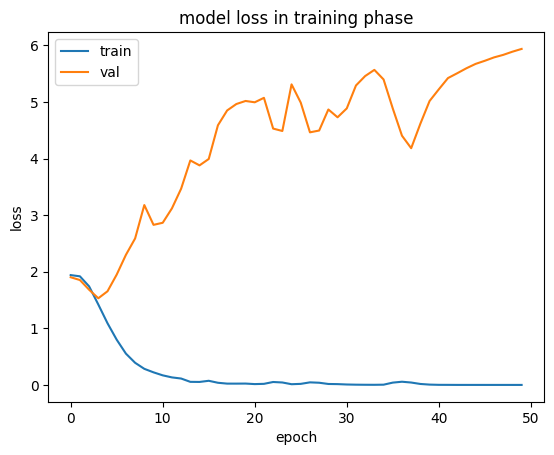

In [ ]:
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Regarding the accuracy of the validation set, it initially increased, then fluctuated.

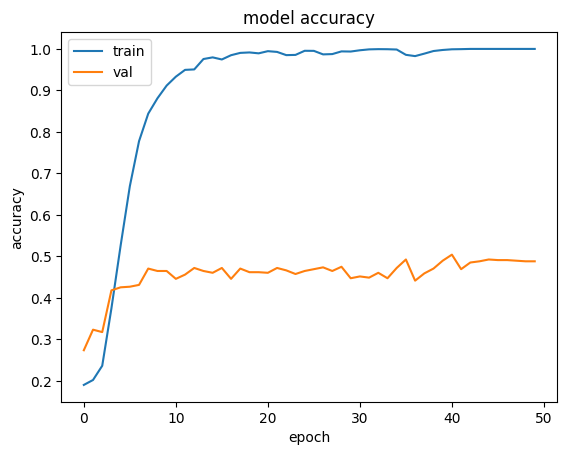

In [ ]:
plt.plot(train_acc_list)
plt.plot(valid_acc_list)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Model Evaluation

I've saved the checkpoints of the trained models and now I'm going to analyze them.

## Using own embedding and LSTM model

In [ ]:
device = "cuda:0"
model0 = get_model(embedding_dim=100, hidden_dim=512, n_layers=2, n_labels=7, bidirectional=True, dropout=0.5, device=device, name_model = 'LSTM', transfer = False)
model0.load_state_dict(torch.load('LSTM_model_own_embed_final.pt'))

<All keys matched successfully>

In [ ]:
test_loss, test_acc = evaluate(model0, test_dataloader, loss_fn, device)
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

Test Loss: 4.741 | Test Acc: 42.14%


## Using W2V embedding and LSTM model

In [ ]:
device = "cuda:0"
model1 = get_model(embedding_dim=100, hidden_dim=512, n_layers=2, n_labels=7, bidirectional=True, dropout=0.5, device=device, name_model = 'LSTM', transfer = True)
model1.load_state_dict(torch.load('LSTM_model_transfer_embed_final.pt'))

<All keys matched successfully>

In [ ]:
test_loss, test_acc = evaluate(model1, test_dataloader, loss_fn, device)
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

Test Loss: 3.990 | Test Acc: 45.45%


Comment: With the same model and hyperparameters, using pre-trained word embeddings has improved the model's prediction results by around 3%.

Transfer learning using pre-trained word embeddings has significant potential in various natural language processing (NLP) tasks. Word embeddings capture semantic relationships and contextual information about words, allowing models to leverage this knowledge to perform better on downstream tasks.

## Using W2V embedding and GRU model

And here is the model that exhibited the best performance throughout the training process.

In [101]:
model2 = get_model(embedding_dim=100, hidden_dim=512, n_layers=2, n_labels=7, bidirectional=True, dropout=0.5, device=device, name_model = 'GRU', transfer = True)
model2.load_state_dict(torch.load('GRU_model_transfer_40.pt'))

<All keys matched successfully>

In [115]:
valid_loss, valid_acc = evaluate(model2, val_dataloader, loss_fn, device)
print(f"Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%")
test_loss, test_acc = evaluate(model2, test_dataloader, loss_fn, device)
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

Valid Loss: 5.222 | Valid Acc: 50.44%
Test Loss: 5.066 | Test Acc: 48.20%


## Report & Analyze

Firstly, let's save the predicted labels by the model for comparison with the actual (human-assigned) labels

In [84]:
y_pred = []
y_true = []

model2.eval()
# iterate over test data
with torch.no_grad():
  for batch in DataLoader(dataset=test_dataset, batch_size=1, collate_fn=test_dataset.collate_fn):
    feedbacks, _ = batch["inputs"]
    feedbacks = feedbacks.to(device)
    logits = model2(feedbacks)
    label = batch["labels"].to(device)
    _, pred = torch.max(logits, dim=1)
    y_pred.extend(pred.data.cpu().numpy()) # Save Prediction
    y_true.extend(label.data.cpu().numpy()) # Save Truth

Calculate and report accuracy, precision, recall, and F1 score:

Accuracy: 0.44
Precision: 0.46
Recall: 0.41
F1 Score: 0.40
Confusion Matrix:


<Axes: >

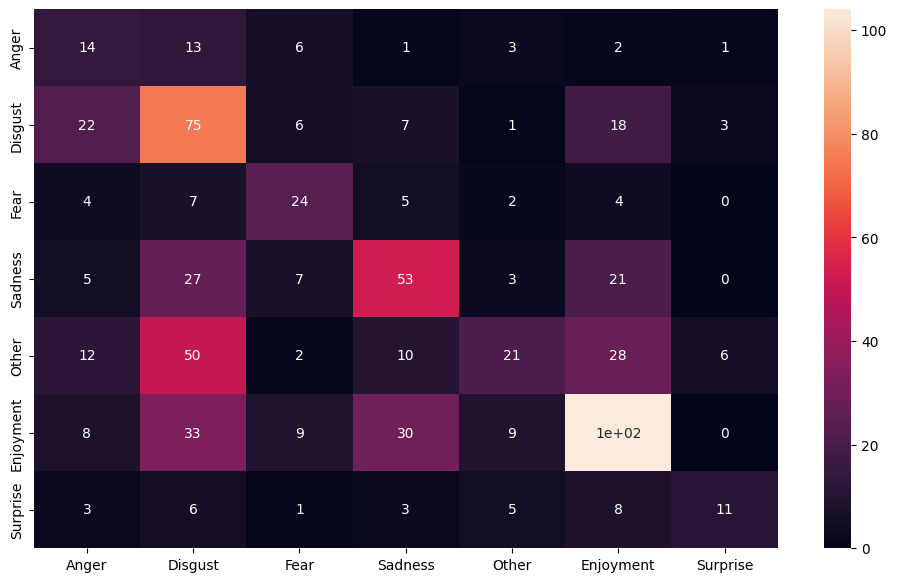

In [127]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # Or 'weighted', 'micro' as per your requirement
recall = recall_score(y_true, y_pred, average='macro')  # Or 'weighted', 'micro' as per your requirement
f1 = f1_score(y_true, y_pred, average='macro')  # Or 'weighted', 'micro' as per your requirement
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = label2id.keys(),
                     columns = label2id.keys())


# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)

Analyze misclassifications and discuss potential reasons:

* The Anger class is often mispredicted as Disgust because these two emotions are challenging to differentiate, even for humans when labeling.
* The Disgust class is commonly mispredicted as Anger or Enjoyment. The confusion with Anger is as mentioned earlier. As for the confusion with Enjoyment, it could be because the Disgust sentence might be sarcastic, mistakenly interpreted as a positive sentiment.
* The Sadness class is frequently mispredicted as Disgust or Enjoyment. This might be due to indirect language use by users, where the model fails to capture the core sentiment of the statement.
* Enjoyment is mispredicted as Sadness and Disgust for similar reasons mentioned above.
* Surprise is mispredicted as Enjoyment due to the positive tone in the sentence.



Now, let's try predicting the label of a sentence in the test set and compare the result with the actual label.

In [86]:
def predict(model, vocab, device, input_text):
    model.eval()
    model.to(device)
    tokens = vocab.corpus_to_tensor([input_text])[0].view(1,-1)
    tokens = tokens.to(device)
    with torch.no_grad():
        logits = model(tokens)
        _, preds = torch.max(logits, dim=-1)
        return id2label[preds.item()]

In [126]:
print(test_data.Sentence[1])
print(predict(model, own_vocab, "cuda:0", test_data.Sentence[1]))
id2label[test_data.Emotion[1]]


cho nghỉ viêc mói đúng sao goi là kỷ luật
Tokenize the corpus...


100%|██████████| 1/1 [00:00<00:00, 4957.81it/s]

Disgust


'Surprise'

The model made the correct prediction!!! This seems to be a happy case :D

# Hyperparameter Tuning

## Tuning Process

I choose optuna, which is a software framework for automating the optimization process of these hyperparameters.

In [55]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.9 MB/s eta 0:00:00


In [108]:
def fit_tuning(model, train_loader, validation_loader, criterion, optimizer, num_epochs = 10):

      for epoch in range(num_epochs):
          # Training
          model.train() # Active training mode of model

          for batch in (pbar:=tqdm(train_loader)):
            optimizer.zero_grad() # clear the gradient

            # forward pass
            feedbacks, _ = batch["inputs"]
            feedbacks = feedbacks.to(device)
            logits = model(feedbacks)
            labels = batch["labels"].to(device)

            loss = criterion(logits, labels)

            # make prediction
            _, preds = torch.max(logits, dim=1)

            # backward pass and update params
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.3)
            optimizer.step()


          # Evaluation
          model.eval() # Active evaluation mode of model
          total_val = 0; correct_val = 0; overall_val_loss = 0.0

          with torch.no_grad():
            for batch in validation_loader:
              feedbacks, _ = batch["inputs"]
              feedbacks = feedbacks.to(device)
              logits = model(feedbacks)
              labels = batch["labels"].to(device)
              loss = criterion(logits, labels)
              _, preds = torch.max(logits, dim=1)
              total_val += labels.size(0)
              correct_val += (preds == labels).sum().item()

              overall_val_loss += loss.item()
      return correct_val/total_val

In [109]:
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

def objective(trial):
    """
    Objective function to be optimized by Optuna.

    Hyperparameters chosen to be optimized: Learning rate, Batch size, Number of epochs.
    """

    # Define range of values to be tested for the hyperparameters
    learning_rate = trial.suggest_float('lr', 0.0001, 0.005)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_int("num_epochs", 30, 80)
    hidden_dim = trial.suggest_categorical('hidden_dim', [128, 256, 512, 1024])
    n_layers = trial.suggest_int("n_layers", 1, 5)
    dropout_rate =  trial.suggest_float('dropout', 0.2, 0.5)

    train_dataloader = DataLoader(train_dataset, batch_size = batch_size, collate_fn=train_dataset.collate_fn)
    val_dataloader = DataLoader(val_dataset, batch_size= batch_size, collate_fn=val_dataset.collate_fn)

    # Generate the model
    model = get_model(embedding_dim=100, hidden_dim=hidden_dim, n_layers=n_layers, n_labels=7, bidirectional=True, dropout=dropout_rate, device=device, name_model = 'GRU', transfer = True)
    #model = get_model(embedding_dim=100, hidden_dim=512, n_layers=2, n_labels=7, bidirectional=True, dropout=0.5, device=device, name_model = 'GRU', transfer = True)
    model.to(device)

    # Generate optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    accuracy = fit_tuning(model, train_loader = train_dataloader, validation_loader = val_dataloader, criterion = criterion, optimizer = optimizer, num_epochs = num_epochs)

    return accuracy

I will perform 10 trials!

In [110]:
import optuna
number_of_trials = 10

# Create an Optuna study to maximize validation accuracy
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=number_of_trials)

# Results
trial = study.best_trial
print("Best trial:")
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-12-27 10:19:59,789] A new study created in memory with name: no-name-1bf4e9a0-cd22-409c-825a-6025d76decc6
100%|██████████| 44/44 [00:02<00:00, 15.22it/s]
[I 2023-12-27 10:23:19,227] Trial 0 finished with value: 0.41253644314868804 and parameters: {'lr': 0.004045200864304976, 'batch_size': 128, 'num_epochs': 66, 'hidden_dim': 512, 'n_layers': 1, 'dropout': 0.4991922782724999}. Best is trial 0 with value: 0.41253644314868804.
100%|██████████| 87/87 [00:05<00:00, 16.58it/s]
[I 2023-12-27 10:26:54,417] Trial 1 finished with value: 0.43440233236151604 and parameters: {'lr': 0.0003701820860230088, 'batch_size': 64, 'num_epochs': 40, 'hidden_dim': 256, 'n_layers': 3, 'dropout': 0.24624303544237602}. Best is trial 1 with value: 0.43440233236151604.
100%|██████████| 174/174 [00:09<00:00, 17.55it/s]
[I 2023-12-27 10:34:21,628] Trial 2 finished with value: 0.46647230320699706 and parameters: {'lr': 0.0006917466438177522, 'batch_size': 32, 'num_epochs': 44, 'hidden_dim': 256, 'n_layers': 3

Best trial:
  Value:  0.4956268221574344
  Params: 
    lr: 0.0012040014335173536
    batch_size: 64
    num_epochs: 48
    hidden_dim: 1024
    n_layers: 2
    dropout: 0.2826899765491363


Best trial:
* Value:  0.4956268221574344
    
* Params

    + lr: 0.0012040014335173536
    + batch_size: 64
    + num_epochs: 48
    + hidden_dim: 1024
    + n_layers: 2
    + dropout: 0.2826899765491363





 ## Model With Hyperparameters Tuned

In [111]:
lr = 0.0012040014335173536
batch_size = 64
num_epochs = 48
hidden_dim = 1024
n_layers = 2
dropout = 0.2826899765491363
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=train_dataset.collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=64, collate_fn=val_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=64, collate_fn=test_dataset.collate_fn)

model = get_model(embedding_dim=100, hidden_dim=hidden_dim, n_layers=n_layers, n_labels=7, bidirectional=True, dropout=dropout, device=device, name_model = 'GRU', transfer = True)
#model = get_model(embedding_dim=100, hidden_dim=512, n_layers=2, n_labels=7, bidirectional=True, dropout=0.5, device=device, name_model = 'GRU', transfer = True)
model.to(device)

# Generate optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

best_valid_acc = 0.44

import time
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_acc = train(model, train_dataloader, optimizer, loss_fn, device)
    valid_loss, valid_acc = evaluate(model, val_dataloader, loss_fn, device)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), f"final_model_tuned_{epoch}.pt")

100%|██████████| 87/87 [00:09<00:00,  9.01it/s, accuracy=0.134, loss=1.91]


Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 1.948 | Train Acc: 13.36%
	 Val. Loss: 1.930 |  Val. Acc: 20.85%


100%|██████████| 87/87 [00:09<00:00,  8.82it/s, accuracy=0.155, loss=1.95]


Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 1.968 | Train Acc: 15.50%
	 Val. Loss: 1.946 |  Val. Acc: 31.20%


100%|██████████| 87/87 [00:09<00:00,  8.71it/s, accuracy=0.138, loss=1.93]


Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 1.960 | Train Acc: 13.81%
	 Val. Loss: 1.961 |  Val. Acc: 21.87%


100%|██████████| 87/87 [00:10<00:00,  8.63it/s, accuracy=0.151, loss=1.93]


Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 1.950 | Train Acc: 15.05%
	 Val. Loss: 1.934 |  Val. Acc: 26.82%


100%|██████████| 87/87 [00:09<00:00,  8.79it/s, accuracy=0.175, loss=1.87]


Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 1.916 | Train Acc: 17.50%
	 Val. Loss: 1.879 |  Val. Acc: 24.93%


100%|██████████| 87/87 [00:09<00:00,  8.72it/s, accuracy=0.242, loss=1.66]


Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 1.755 | Train Acc: 24.19%
	 Val. Loss: 1.863 |  Val. Acc: 17.64%


100%|██████████| 87/87 [00:09<00:00,  8.99it/s, accuracy=0.319, loss=1.32]


Epoch: 07 | Epoch Time: 0m 9s
	Train Loss: 1.505 | Train Acc: 31.89%
	 Val. Loss: 1.811 |  Val. Acc: 25.80%


100%|██████████| 87/87 [00:09<00:00,  8.93it/s, accuracy=0.413, loss=1.01]


Epoch: 08 | Epoch Time: 0m 9s
	Train Loss: 1.293 | Train Acc: 41.28%
	 Val. Loss: 1.817 |  Val. Acc: 32.65%


100%|██████████| 87/87 [00:09<00:00,  8.91it/s, accuracy=0.476, loss=0.994]


Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 1.133 | Train Acc: 47.64%
	 Val. Loss: 1.911 |  Val. Acc: 43.00%


100%|██████████| 87/87 [00:09<00:00,  8.80it/s, accuracy=0.593, loss=0.57]


Epoch: 10 | Epoch Time: 0m 10s
	Train Loss: 0.903 | Train Acc: 59.34%
	 Val. Loss: 2.183 |  Val. Acc: 38.34%


100%|██████████| 87/87 [00:09<00:00,  8.87it/s, accuracy=0.706, loss=0.372]


Epoch: 11 | Epoch Time: 0m 10s
	Train Loss: 0.693 | Train Acc: 70.62%
	 Val. Loss: 2.126 |  Val. Acc: 40.96%


100%|██████████| 87/87 [00:09<00:00,  8.87it/s, accuracy=0.819, loss=0.176]


Epoch: 12 | Epoch Time: 0m 10s
	Train Loss: 0.407 | Train Acc: 81.90%
	 Val. Loss: 2.648 |  Val. Acc: 43.15%


100%|██████████| 87/87 [00:09<00:00,  8.90it/s, accuracy=0.897, loss=0.175]


Epoch: 13 | Epoch Time: 0m 9s
	Train Loss: 0.241 | Train Acc: 89.65%
	 Val. Loss: 3.658 |  Val. Acc: 45.04%


100%|██████████| 87/87 [00:09<00:00,  8.86it/s, accuracy=0.924, loss=0.128]


Epoch: 14 | Epoch Time: 0m 10s
	Train Loss: 0.166 | Train Acc: 92.45%
	 Val. Loss: 3.695 |  Val. Acc: 44.17%


100%|██████████| 87/87 [00:09<00:00,  8.83it/s, accuracy=0.924, loss=0.127]


Epoch: 15 | Epoch Time: 0m 10s
	Train Loss: 0.175 | Train Acc: 92.38%
	 Val. Loss: 3.472 |  Val. Acc: 44.17%


100%|██████████| 87/87 [00:09<00:00,  8.88it/s, accuracy=0.921, loss=0.0848]


Epoch: 16 | Epoch Time: 0m 9s
	Train Loss: 0.180 | Train Acc: 92.11%
	 Val. Loss: 3.581 |  Val. Acc: 42.42%


100%|██████████| 87/87 [00:09<00:00,  8.90it/s, accuracy=0.948, loss=0.114]


Epoch: 17 | Epoch Time: 0m 9s
	Train Loss: 0.126 | Train Acc: 94.84%
	 Val. Loss: 4.044 |  Val. Acc: 45.04%


100%|██████████| 87/87 [00:09<00:00,  8.85it/s, accuracy=0.963, loss=0.382]


Epoch: 18 | Epoch Time: 0m 10s
	Train Loss: 0.096 | Train Acc: 96.30%
	 Val. Loss: 4.595 |  Val. Acc: 39.21%


100%|██████████| 87/87 [00:09<00:00,  8.92it/s, accuracy=0.956, loss=0.48]


Epoch: 19 | Epoch Time: 0m 9s
	Train Loss: 0.118 | Train Acc: 95.60%
	 Val. Loss: 4.577 |  Val. Acc: 37.76%


100%|██████████| 87/87 [00:09<00:00,  8.92it/s, accuracy=0.95, loss=0.00614]


Epoch: 20 | Epoch Time: 0m 9s
	Train Loss: 0.120 | Train Acc: 94.97%
	 Val. Loss: 4.271 |  Val. Acc: 42.86%


100%|██████████| 87/87 [00:09<00:00,  8.86it/s, accuracy=0.956, loss=0.0129]


Epoch: 21 | Epoch Time: 0m 10s
	Train Loss: 0.105 | Train Acc: 95.64%
	 Val. Loss: 4.286 |  Val. Acc: 43.29%


100%|██████████| 87/87 [00:09<00:00,  8.90it/s, accuracy=0.975, loss=0.0399]


Epoch: 22 | Epoch Time: 0m 9s
	Train Loss: 0.058 | Train Acc: 97.53%
	 Val. Loss: 4.944 |  Val. Acc: 43.44%


100%|██████████| 87/87 [00:09<00:00,  8.94it/s, accuracy=0.988, loss=0.00284]


Epoch: 23 | Epoch Time: 0m 9s
	Train Loss: 0.032 | Train Acc: 98.77%
	 Val. Loss: 5.218 |  Val. Acc: 44.31%


100%|██████████| 87/87 [00:09<00:00,  8.87it/s, accuracy=0.988, loss=0.00181]


Epoch: 24 | Epoch Time: 0m 10s
	Train Loss: 0.031 | Train Acc: 98.76%
	 Val. Loss: 5.391 |  Val. Acc: 44.61%


100%|██████████| 87/87 [00:09<00:00,  8.91it/s, accuracy=0.987, loss=0.00442]


Epoch: 25 | Epoch Time: 0m 9s
	Train Loss: 0.037 | Train Acc: 98.67%
	 Val. Loss: 5.280 |  Val. Acc: 46.65%


100%|██████████| 87/87 [00:09<00:00,  8.91it/s, accuracy=0.986, loss=0.0255]


Epoch: 26 | Epoch Time: 0m 9s
	Train Loss: 0.046 | Train Acc: 98.59%
	 Val. Loss: 5.269 |  Val. Acc: 39.65%


100%|██████████| 87/87 [00:09<00:00,  8.82it/s, accuracy=0.977, loss=0.0097]


Epoch: 27 | Epoch Time: 0m 10s
	Train Loss: 0.058 | Train Acc: 97.71%
	 Val. Loss: 4.893 |  Val. Acc: 44.46%


100%|██████████| 87/87 [00:09<00:00,  8.87it/s, accuracy=0.982, loss=0.0192]


Epoch: 28 | Epoch Time: 0m 10s
	Train Loss: 0.057 | Train Acc: 98.16%
	 Val. Loss: 5.531 |  Val. Acc: 43.44%


100%|██████████| 87/87 [00:09<00:00,  8.88it/s, accuracy=0.983, loss=0.00559]


Epoch: 29 | Epoch Time: 0m 9s
	Train Loss: 0.043 | Train Acc: 98.34%
	 Val. Loss: 5.246 |  Val. Acc: 42.57%


100%|██████████| 87/87 [00:09<00:00,  8.89it/s, accuracy=0.983, loss=0.00341]


Epoch: 30 | Epoch Time: 0m 9s
	Train Loss: 0.046 | Train Acc: 98.34%
	 Val. Loss: 5.816 |  Val. Acc: 42.27%


100%|██████████| 87/87 [00:09<00:00,  8.86it/s, accuracy=0.987, loss=0.0286]


Epoch: 31 | Epoch Time: 0m 10s
	Train Loss: 0.030 | Train Acc: 98.74%
	 Val. Loss: 5.844 |  Val. Acc: 43.88%


100%|██████████| 87/87 [00:09<00:00,  8.92it/s, accuracy=0.991, loss=0.0183]


Epoch: 32 | Epoch Time: 0m 9s
	Train Loss: 0.027 | Train Acc: 99.12%
	 Val. Loss: 5.626 |  Val. Acc: 43.88%


100%|██████████| 87/87 [00:09<00:00,  8.93it/s, accuracy=0.994, loss=0.00151]


Epoch: 33 | Epoch Time: 0m 9s
	Train Loss: 0.017 | Train Acc: 99.39%
	 Val. Loss: 5.994 |  Val. Acc: 44.31%


100%|██████████| 87/87 [00:09<00:00,  8.94it/s, accuracy=0.996, loss=0.0046]


Epoch: 34 | Epoch Time: 0m 9s
	Train Loss: 0.010 | Train Acc: 99.62%
	 Val. Loss: 6.197 |  Val. Acc: 43.88%


100%|██████████| 87/87 [00:09<00:00,  8.93it/s, accuracy=0.994, loss=0.0154]


Epoch: 35 | Epoch Time: 0m 9s
	Train Loss: 0.016 | Train Acc: 99.44%
	 Val. Loss: 5.692 |  Val. Acc: 44.46%


100%|██████████| 87/87 [00:09<00:00,  8.93it/s, accuracy=0.994, loss=0.094]


Epoch: 36 | Epoch Time: 0m 9s
	Train Loss: 0.017 | Train Acc: 99.37%
	 Val. Loss: 6.282 |  Val. Acc: 46.21%


100%|██████████| 87/87 [00:09<00:00,  8.90it/s, accuracy=0.996, loss=0.00081]


Epoch: 37 | Epoch Time: 0m 9s
	Train Loss: 0.016 | Train Acc: 99.62%
	 Val. Loss: 6.346 |  Val. Acc: 44.61%


100%|██████████| 87/87 [00:09<00:00,  8.88it/s, accuracy=0.996, loss=0.000395]


Epoch: 38 | Epoch Time: 0m 9s
	Train Loss: 0.009 | Train Acc: 99.60%
	 Val. Loss: 6.419 |  Val. Acc: 44.46%


100%|██████████| 87/87 [00:09<00:00,  8.88it/s, accuracy=0.997, loss=0.000453]


Epoch: 39 | Epoch Time: 0m 10s
	Train Loss: 0.006 | Train Acc: 99.75%
	 Val. Loss: 6.505 |  Val. Acc: 46.21%


100%|██████████| 87/87 [00:09<00:00,  8.90it/s, accuracy=0.999, loss=0.0033]


Epoch: 40 | Epoch Time: 0m 9s
	Train Loss: 0.004 | Train Acc: 99.87%
	 Val. Loss: 6.925 |  Val. Acc: 47.38%


100%|██████████| 87/87 [00:09<00:00,  8.81it/s, accuracy=1, loss=5.71e-5]


Epoch: 41 | Epoch Time: 0m 10s
	Train Loss: 0.002 | Train Acc: 99.96%
	 Val. Loss: 6.957 |  Val. Acc: 45.19%


100%|██████████| 87/87 [00:09<00:00,  8.89it/s, accuracy=1, loss=4.75e-5]


Epoch: 42 | Epoch Time: 0m 9s
	Train Loss: 0.002 | Train Acc: 99.98%
	 Val. Loss: 7.069 |  Val. Acc: 45.04%


100%|██████████| 87/87 [00:09<00:00,  8.90it/s, accuracy=1, loss=3.48e-5]


Epoch: 43 | Epoch Time: 0m 9s
	Train Loss: 0.001 | Train Acc: 99.96%
	 Val. Loss: 6.788 |  Val. Acc: 45.48%


100%|██████████| 87/87 [00:10<00:00,  8.57it/s, accuracy=1, loss=4.29e-5]


Epoch: 44 | Epoch Time: 0m 10s
	Train Loss: 0.002 | Train Acc: 99.98%
	 Val. Loss: 6.869 |  Val. Acc: 45.19%


100%|██████████| 87/87 [00:09<00:00,  8.93it/s, accuracy=1, loss=5.52e-5]


Epoch: 45 | Epoch Time: 0m 9s
	Train Loss: 0.002 | Train Acc: 99.98%
	 Val. Loss: 6.994 |  Val. Acc: 44.75%


100%|██████████| 87/87 [00:09<00:00,  8.95it/s, accuracy=1, loss=5.66e-5]


Epoch: 46 | Epoch Time: 0m 9s
	Train Loss: 0.001 | Train Acc: 99.98%
	 Val. Loss: 7.095 |  Val. Acc: 44.75%


100%|██████████| 87/87 [00:09<00:00,  8.92it/s, accuracy=1, loss=4.45e-5]


Epoch: 47 | Epoch Time: 0m 9s
	Train Loss: 0.001 | Train Acc: 99.96%
	 Val. Loss: 6.835 |  Val. Acc: 44.61%


100%|██████████| 87/87 [00:09<00:00,  8.93it/s, accuracy=1, loss=0.000106]


Epoch: 48 | Epoch Time: 0m 9s
	Train Loss: 0.001 | Train Acc: 99.98%
	 Val. Loss: 6.981 |  Val. Acc: 44.75%


In [112]:
torch.save(model.state_dict(), f"final_tuned_model.pt")

In [122]:
#model.load_state_dict(torch.load('final_tuned_model.pt'))
model.load_state_dict(torch.load('final_model_tuned_39.pt'))
valid_loss, valid_acc = evaluate(model, val_dataloader, loss_fn, device)
print(f"Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%")
test_loss, test_acc = evaluate(model, test_dataloader, loss_fn, device)
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

Valid Loss: 6.925 | Valid Acc: 47.38%
Test Loss: 6.760 | Test Acc: 46.90%


Due to the considerable hyperparameter space and limited experimentation, the model's performance has been no enhancement. However, with more trials, there's a high probability that we'll discover a suitable set of hyperparameters that could optimize the model's performance.

# Discussion and Analysis

## Challenges and Insights



1.   Challenges


*   The data is limited, with just over 5000 data points in the train dataset.

*   The data quality is low: many abbreviations, misspellings, emojis, and emoticons...
* Many sentences are prone to misunderstandings about emotions, and sometimes pre-assigned labels are not appropriate.
* Limited knowledge about NLP models, using basic models resulting in overfitting.
* Insufficient hardware resources to support multiple training and tuning sessions.

2.   Insights


*   Data preprocessing is incredibly crucial; improving the quality of input data sometimes yields better results than improving the model itself, especially in cases with limited datasets like this problem.
*   Transfer learning using pre-trained word embeddings has significant potential in various natural language processing (NLP) tasks. Word embeddings capture semantic relationships and contextual information about words, allowing models to leverage this knowledge to perform better on downstream tasks.




## The model's performance

I'd like to summarize the loss and accuracy of the best-performing model (GRU with transfer learning) across the three datasets:

In [117]:
train_loss, train_acc = evaluate(model2, train_dataloader, loss_fn, device)
print(f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
valid_loss, valid_acc = evaluate(model2, val_dataloader, loss_fn, device)
print(f"Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%")
test_loss, test_acc = evaluate(model2, test_dataloader, loss_fn, device)
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

Train Loss: 0.009 | Train Acc: 99.75%
Valid Loss: 5.222 | Valid Acc: 50.44%
Test Loss: 5.066 | Test Acc: 48.20%


## Visualization to understand more about the model's performance




### Monitor the training process

I suspect that due to the limited data, the model tends to overfit, indicated by the decreasing training loss but increasing validation loss.

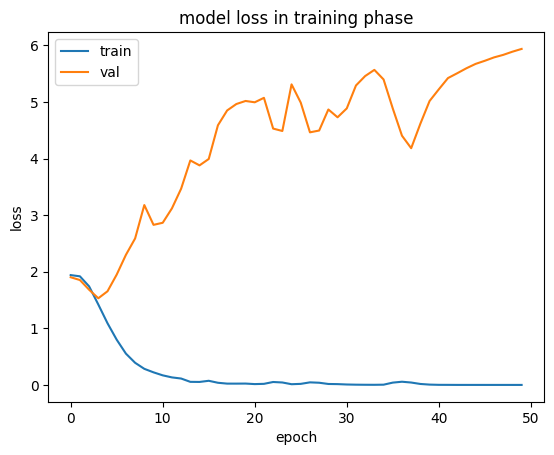

In [ ]:
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Regarding the accuracy of the validation set, it initially increased, then fluctuated.

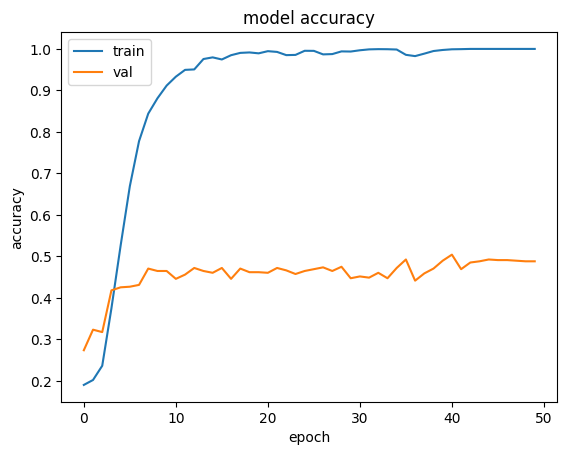

In [ ]:
plt.plot(train_acc_list)
plt.plot(valid_acc_list)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Confusion matrice

Confusion Matrix:


<Axes: >

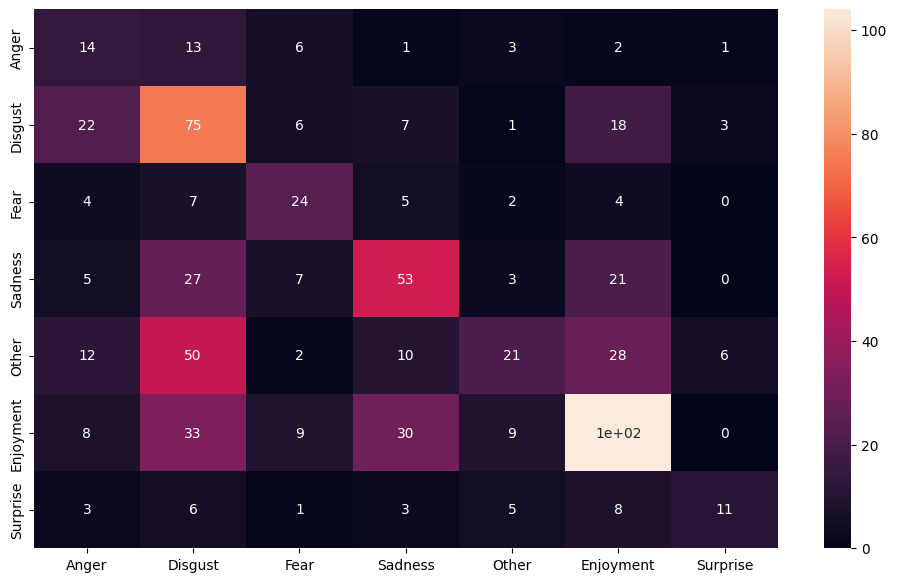

In [128]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = label2id.keys(),
                     columns = label2id.keys())

print("Confusion Matrix:")
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)

* The Anger class is often mispredicted as Disgust because these two emotions are challenging to differentiate, even for humans when labeling.
* The Disgust class is commonly mispredicted as Anger or Enjoyment. The confusion with Anger is as mentioned earlier. As for the confusion with Enjoyment, it could be because the Disgust sentence might be sarcastic, mistakenly interpreted as a positive sentiment.
* The Sadness class is frequently mispredicted as Disgust or Enjoyment. This might be due to indirect language use by users, where the model fails to capture the core sentiment of the statement.
* Enjoyment is mispredicted as Sadness and Disgust for similar reasons mentioned above.
* Surprise is mispredicted as Enjoyment due to the positive tone in the sentence.

### Classification report

In [123]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.35      0.26        40
           1       0.36      0.57      0.44       132
           2       0.44      0.52      0.48        46
           3       0.49      0.46      0.47       116
           4       0.48      0.16      0.24       129
           5       0.56      0.54      0.55       193
           6       0.52      0.30      0.38        37

    accuracy                           0.44       693
   macro avg       0.44      0.41      0.40       693
weighted avg       0.46      0.44      0.43       693



In [129]:
id2label

{0: 'Anger',
 1: 'Disgust',
 2: 'Fear',
 3: 'Sadness',
 4: 'Other',
 5: 'Enjoyment',
 6: 'Surprise'}

Looking at the data, we observe that the three classes: Enjoyment, Fear, and Sadness perform the best. The underlying reason for this superior performance might stem from these emotions being more distinguishable or having more representative data, allowing the model to learn more effectively.

## The importance of hyperparameter tuning

Hyperparameter tuning assists in selecting suitable hyperparameter sets for a specific problem's model. If executed well (and luckily), this process can enhance the model's performance. It's a crucial step in optimizing a model for a specific task, helping it achieve better results and greater efficiency.

## Further improvement

We can increase performance by improving the quality of the input data or trying advanced models:


*   Spelling correction and acronyms, abbreviations
lookup, removing particular words...

*   Try: Text-CNN, bidirectional transformers (BERT), multilingual model (XLM-R)...



# References

Exploiting Vietnamese Social Media Characteristics for Textual Emotion Recognition in Vietnamese https://arxiv.org/abs/2009.11005


A New Approach for Vietnamese Aspect-Based Sentiment Analysis https://ieeexplore.ieee.org/document/9953759

Emotion Recognition for Vietnamese Social Media Text https://arxiv.org/abs/1911.09339


Improving Sentiment Analysis By Emotion Lexicon Approach on Vietnamese Texts https://arxiv.org/abs/2210.02063

GRU https://pytorch.org/docs/stable/generated/torch.nn.GRU.html#torch.nn.GRU